In [3]:
import numpy as np 
import pandas as pd 
import missingno as msno
from math import floor
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import  plot_confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_theme()
sns.set_palette('colorblind')

Id                   0
Date                 1
Location             1
MinTemp            328
MaxTemp            166
Rainfall           604
Evaporation      26804
Sunshine         31884
WindGustDir       4239
WindGustSpeed     4233
WindDir9am        4863
WindDir3pm        1935
WindSpeed9am       890
WindSpeed3pm      1358
Humidity9am        785
Humidity3pm       1140
Pressure9am       7681
Pressure3pm       7649
Cloud9am         20243
Cloud3pm         20920
Temp9am            556
Temp3pm            955
RainToday          604
RainTomorrow         1
dtype: int64

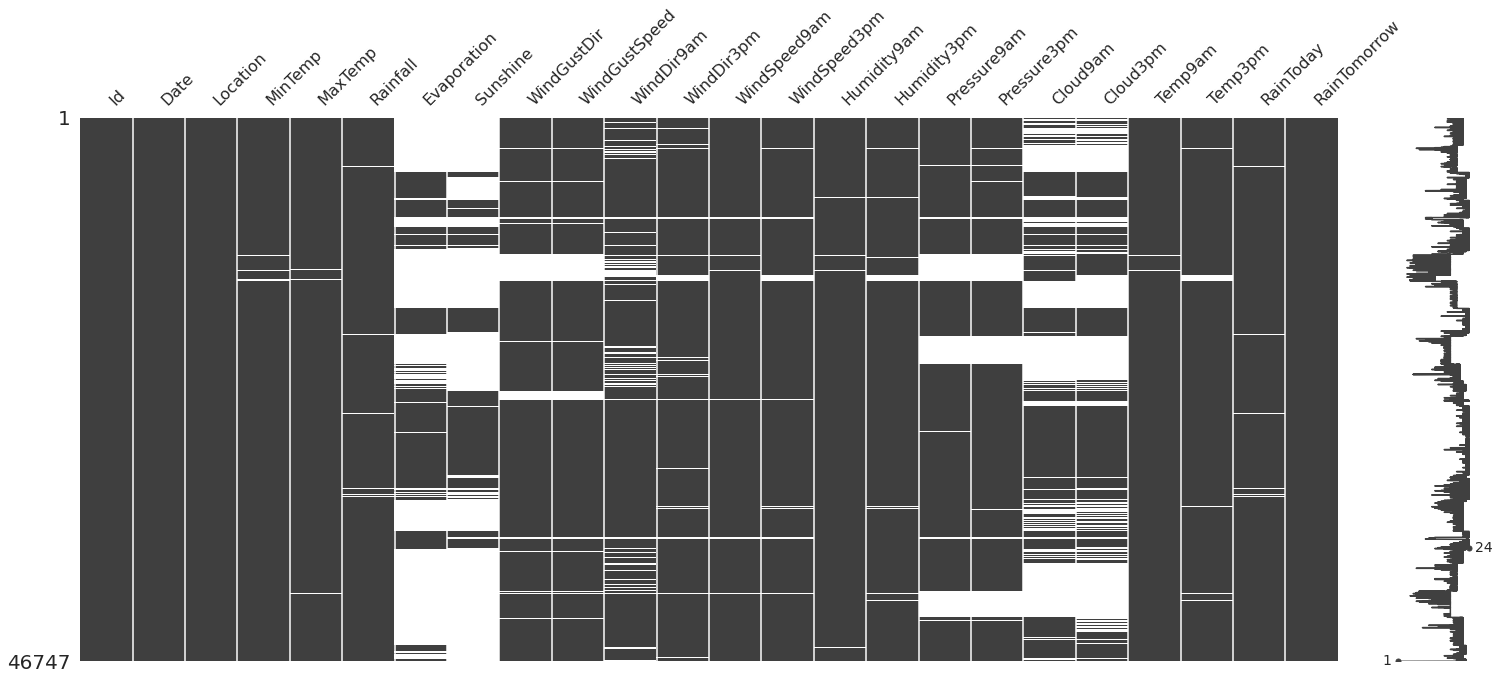

In [4]:
df = pd.read_csv('train.csv', dtype={'Date':str})
test_df = pd.read_csv('test.csv', dtype={'Date':str})

df.set_index('Id')
test_df.set_index('Id')

msno.matrix(df)
df.isna().sum()

In [5]:
df.drop(["Evaporation","Sunshine","Cloud9am","Cloud3pm"], axis = 1, inplace = True)
df.dropna(axis=0,subset=['RainTomorrow'], inplace= True)


In [6]:
df['Year'] = pd.to_datetime(df['Date']).dt.year
df['Day_of_year'] = pd.to_datetime(df['Date']).dt.dayofyear

test_df['Year'] = pd.to_datetime(test_df['Date']).dt.year
test_df['Day_of_year'] = pd.to_datetime(test_df['Date']).dt.dayofyear

df.sort_values(by = ['Location','Year','Day_of_year'],inplace = True)
df.fillna(method = 'ffill', limit = 10, inplace = True)

test_df.sort_values(by = ['Location','Year','Day_of_year'],inplace = True)
test_df.fillna(method = 'ffill', limit = 10, inplace = True)

In [7]:
df.drop(["Location", "Date"], axis =1,inplace= True)
df.dropna(axis=0,how="any",inplace= True)
df.reset_index(drop = True, inplace = True)
df.isna().sum()

test_df.drop(["Location", "Date"], axis =1,inplace= True)
test_df.dropna(axis=0,how="any",inplace= True)
test_df.reset_index(drop = True, inplace = True)

(38462, 20)
No     0.776689
Yes    0.223311
Name: RainTomorrow, dtype: float64


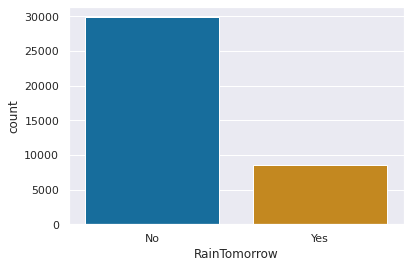

In [8]:
print(df.shape)
print(df['RainTomorrow'].value_counts(normalize = True))
sns.countplot(x='RainTomorrow', data=df)

,Id,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,Year,Day_of_year
count,38462.000000,38462.000000,38462.000000,38462.000000,38462.000000,38462.000000,38462.000000,38462.000000,38462.000000,38462.000000,38462.000000,38462.000000,38462.000000,38462.000000,38462.000000
mean,29724.922729,11.848266,22.827411,2.537806,39.661224,13.895793,18.813114,70.413343,52.125708,1018.311474,1015.813106,16.522230,21.381184,2012.666294,178.273387
std,17677.027889,6.329957,6.454887,8.868308,13.724453,9.032265,9.108227,17.587358,20.683648,6.906296,6.789488,5.897436,6.274676,2.514252,104.662245
min,2.000000,-8.200000,2.600000,0.000000,7.000000,0.000000,0.000000,6.000000,1.000000,980.500000,979.000000,-3.100000,1.700000,2007.000000,1.000000
25%,12701.500000,7.300000,18.300000,0.000000,30.000000,7.000000,13.000000,59.000000,37.000000,1013.700000,1011.300000,12.400000,17.100000,2010.000000,88.000000
50%,32112.500000,12.300000,22.400000,0.000000,37.000000,13.000000,19.000000,71.000000,52.000000,1018.400000,1015.900000,17.000000,21.000000,2013.000000,174.000000
75%,44519.750000,16.900000,26.900000,0.600000,48.000000,19.000000,24.000000,84.000000,67.000000,1022.900000,1020.400000,20.900000,25.200000,2015.000000,268.000000
max,59815.000000,29.400000,47.300000,371.000000,135.000000,87.000000,74.000000,100.000000,100.000000,1040.600000,1037.800000,37.700000,45.900000,2017.000000,366.000000


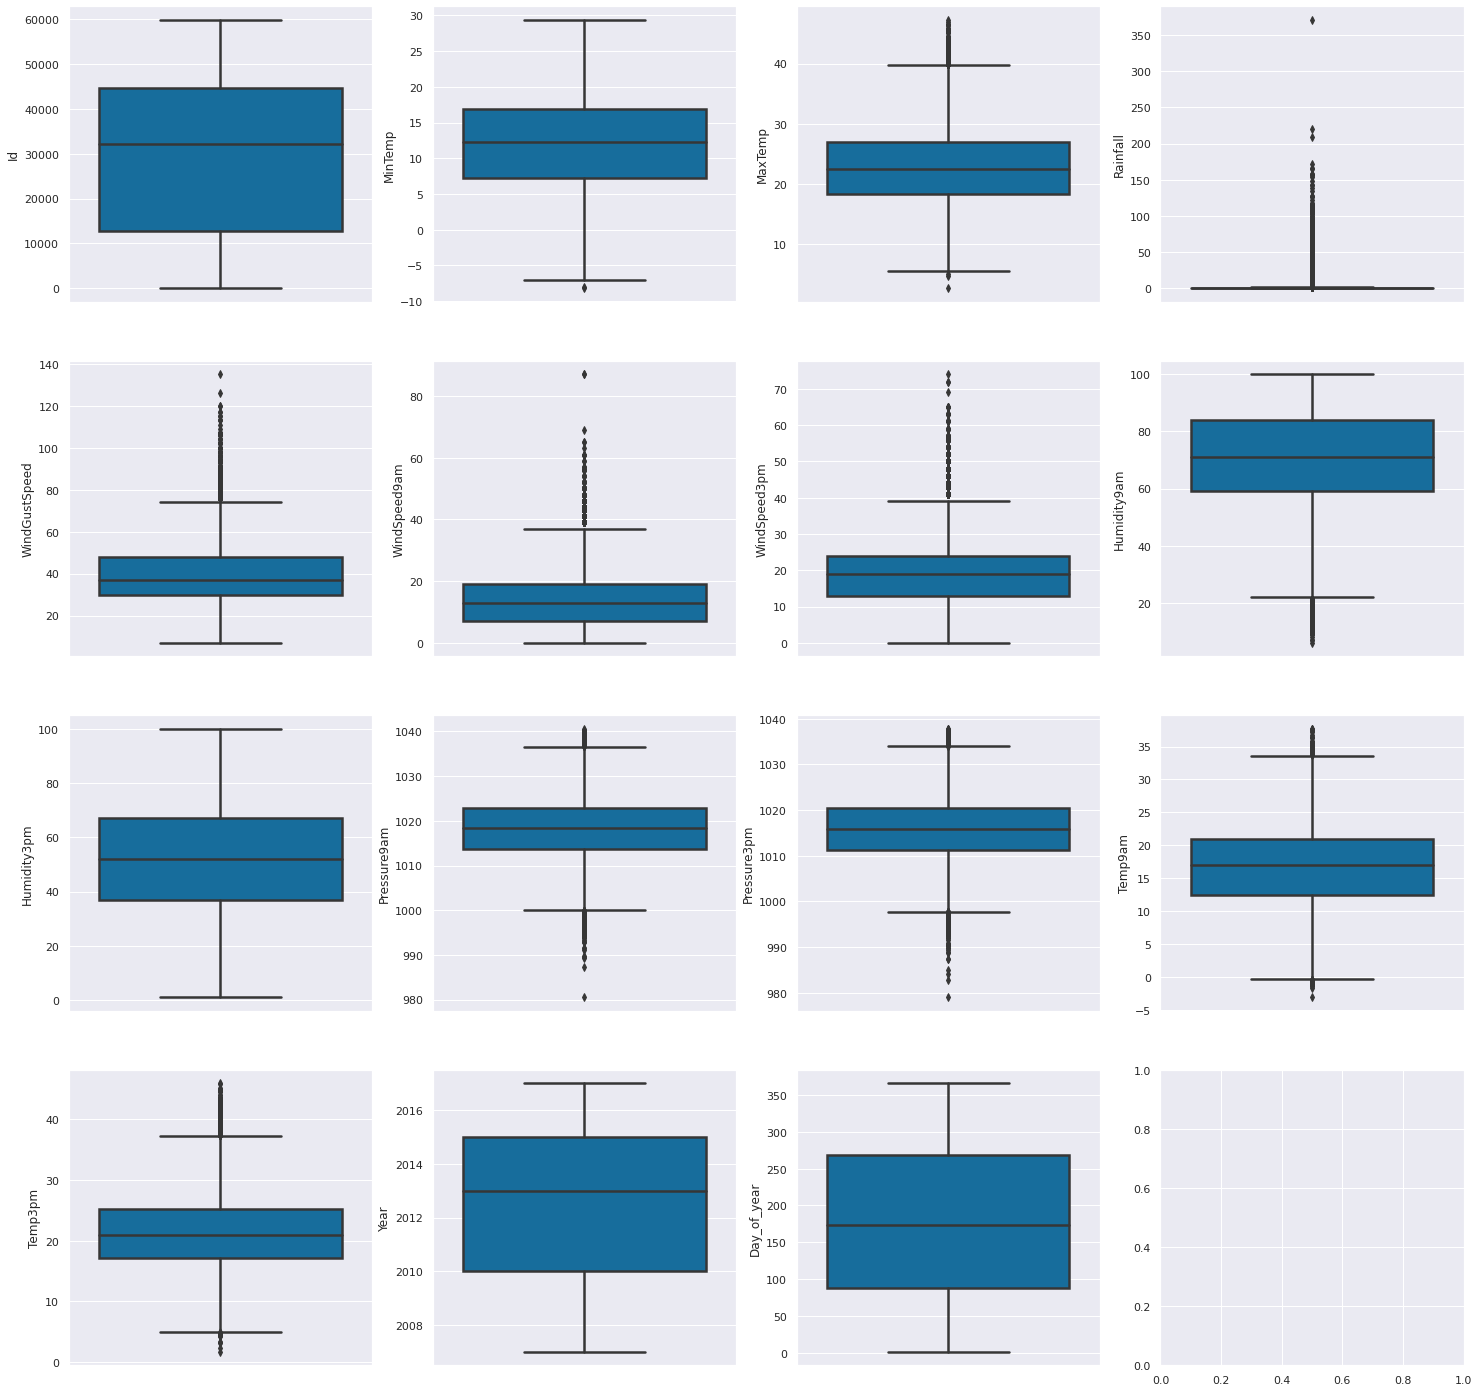

In [9]:
cat_cols = df.columns[(df.dtypes=='O') & (df.columns!='RainTomorrow')]
num_cols = df.columns[df.dtypes!='O']

fig, axes = plt.subplots(4,4,figsize=(25, 25))
for i,col in enumerate(num_cols):
    plt_col = i%4
    plt_row = floor(i/4)
    sns.boxplot(ax = axes[plt_row,plt_col], data = df, y = col, linewidth=2.5)
df.describe()

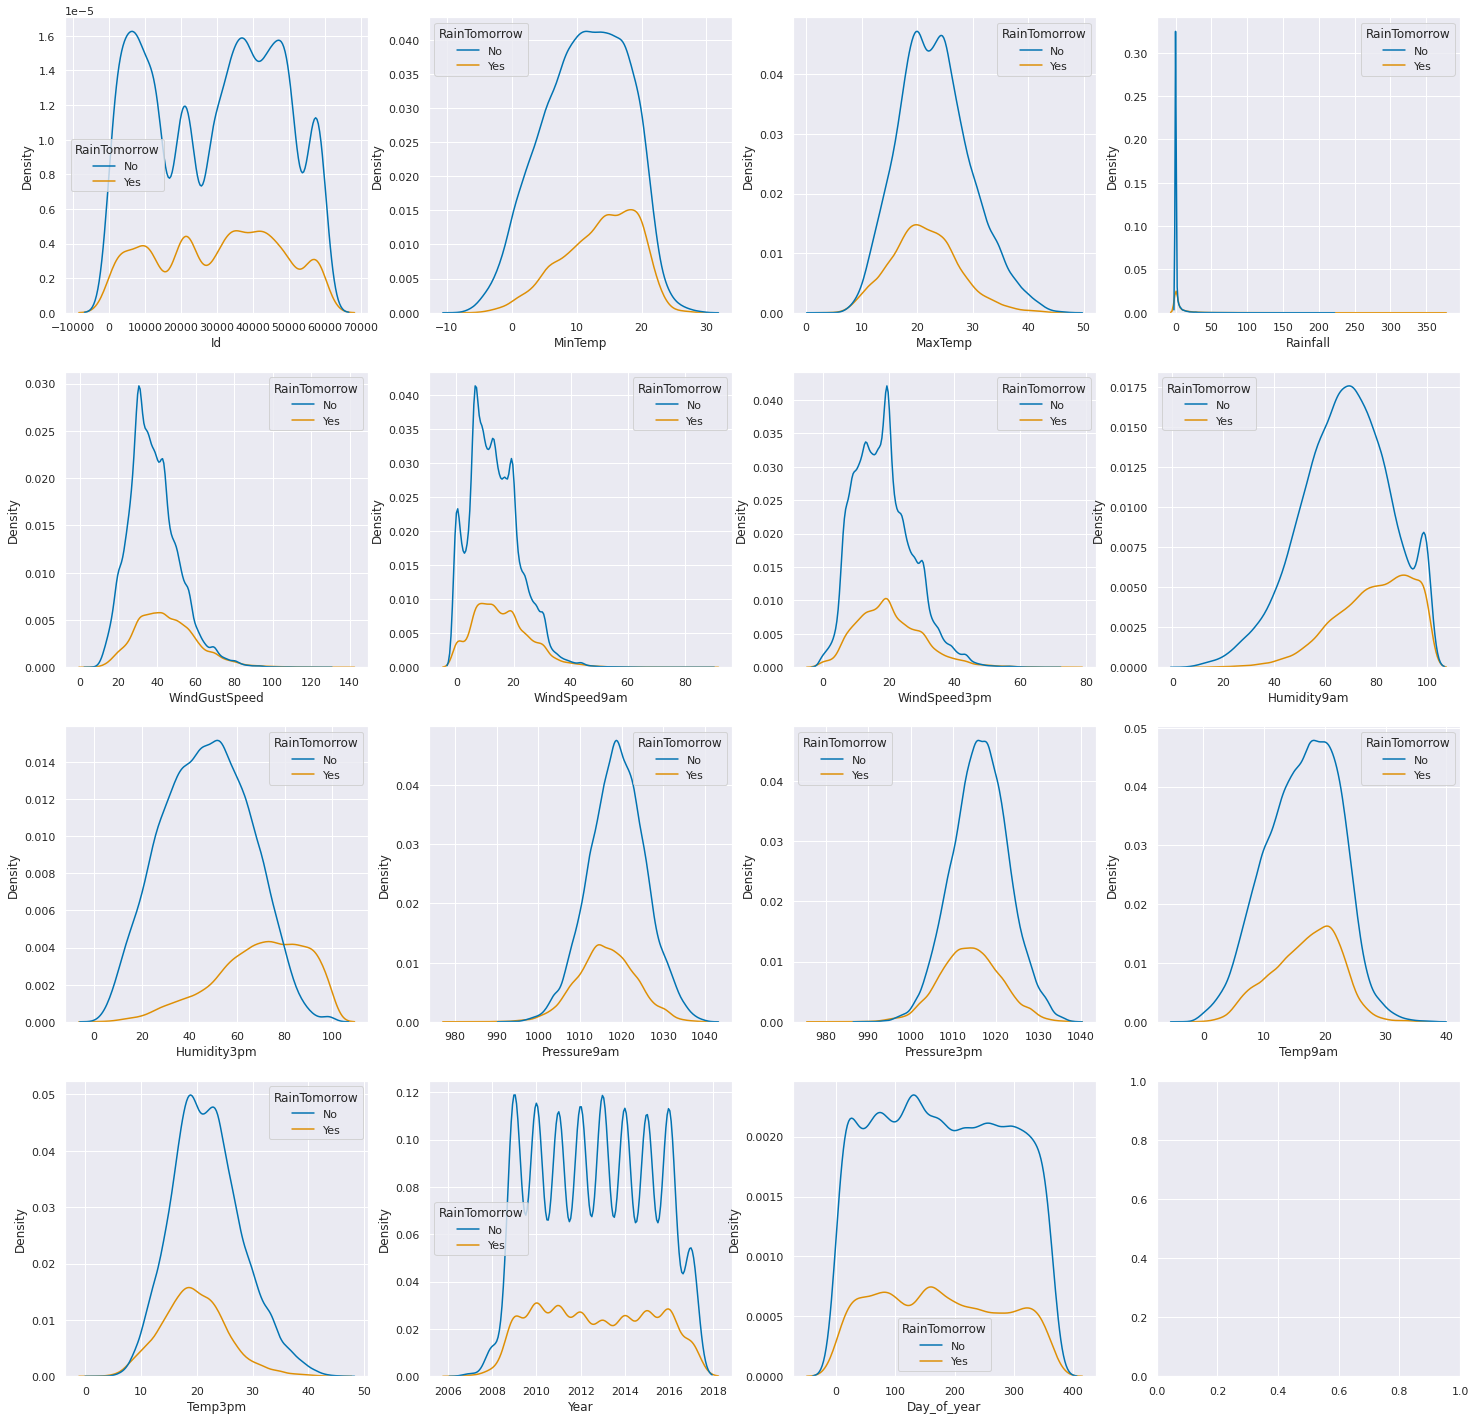

In [10]:
fig, axes = plt.subplots(4,4,figsize=(25, 25))
for i,col in enumerate(num_cols):
    plt_col = i%4
    plt_row = floor(i/4)
    sns.kdeplot(ax = axes[plt_row,plt_col], data = df, x = col, hue = "RainTomorrow")

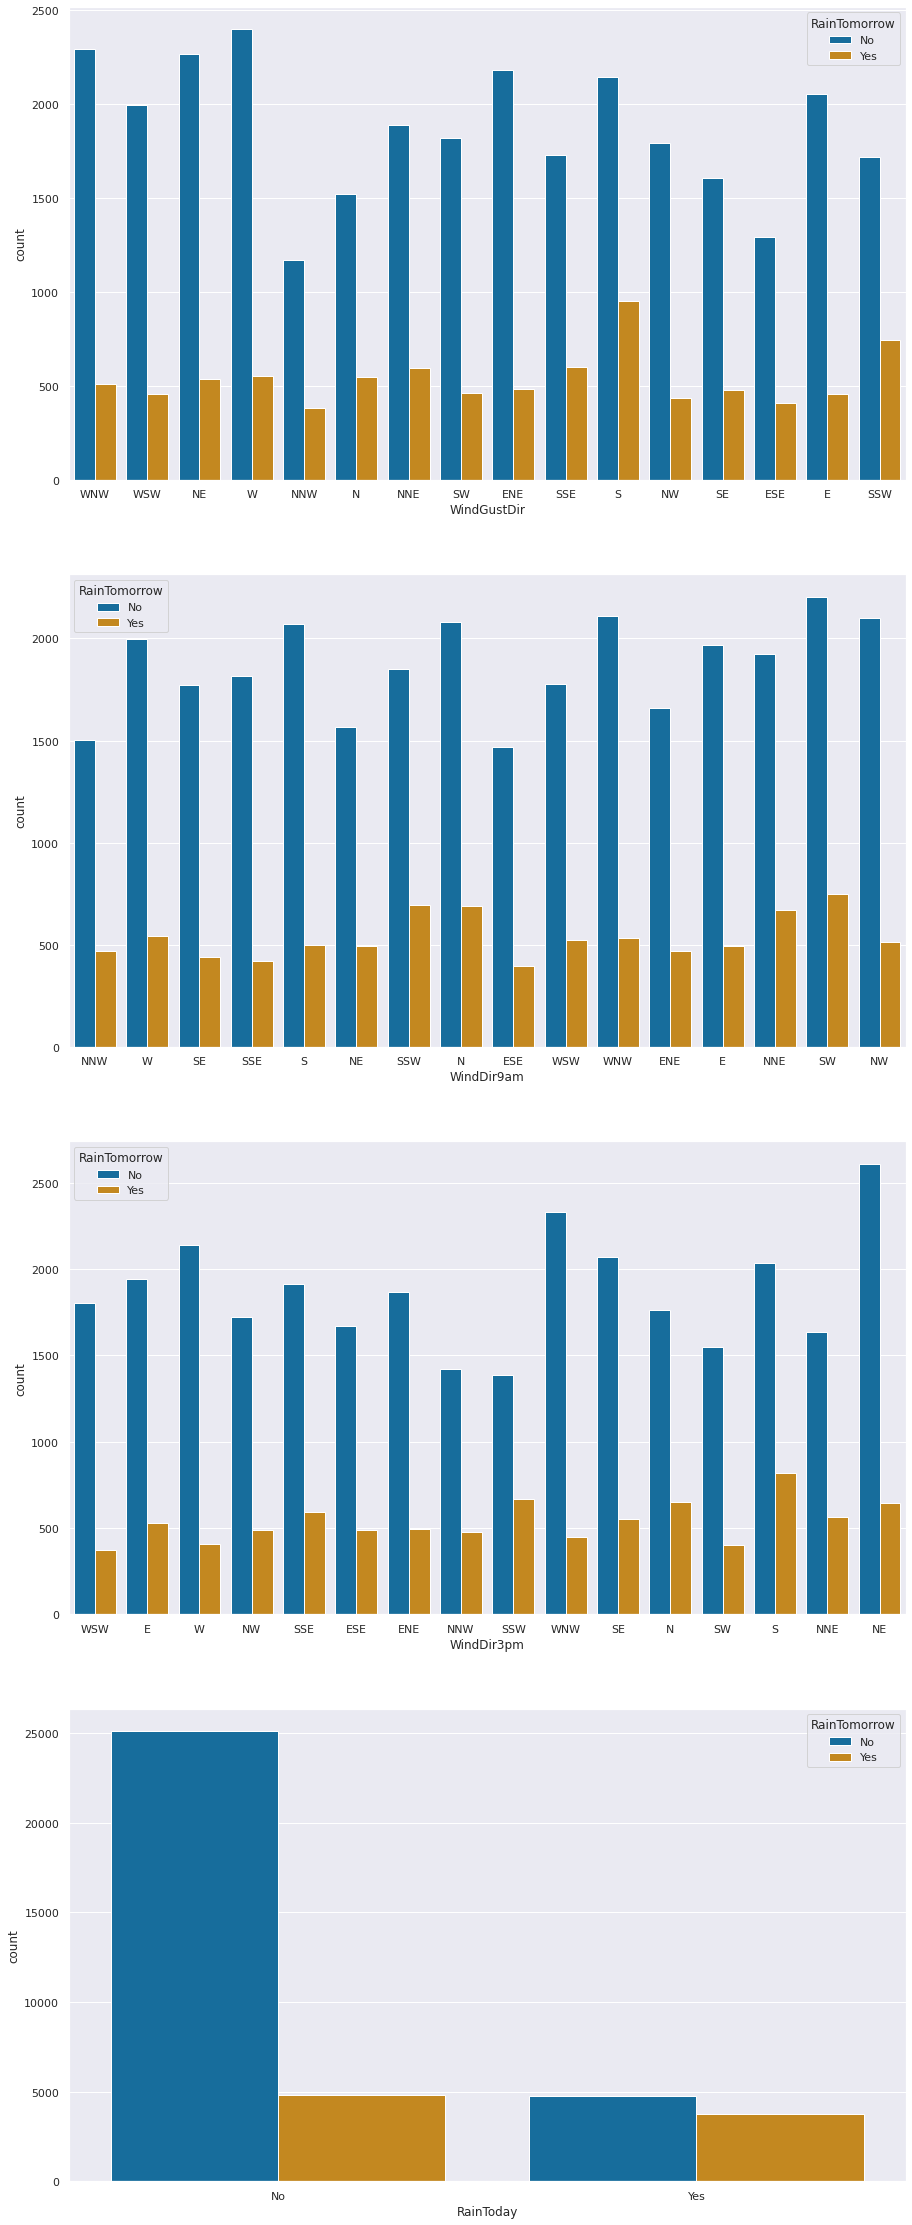

In [11]:
fig, axes = plt.subplots(4,1,figsize=(15, 40))
for i,col in enumerate(cat_cols):
    chart = sns.countplot(ax =axes[i],x= col ,hue = 'RainTomorrow' ,data = df)

In [12]:
dirangle_map = {'N':0, 'NNE':22.5, 'NE':45, 'ENE':67.5, 'E':90, 'ESE': 112.5, 'SE':135, 'SSE':157.5, 'S':180, 'SSW':202.5, 'SW':225, 'WSW':247.5, 'W':270, 'WNW':292.5, 'NW':315, 'NNW':337.5 }
bool_map = {'No':0, 'Yes':1}

df.replace({"WindGustDir": dirangle_map, 'WindDir9am':dirangle_map, 'WindDir3pm':dirangle_map, 'RainToday':bool_map, 'RainTomorrow':bool_map }, inplace = True)
test_df.replace({"WindGustDir": dirangle_map, 'WindDir9am':dirangle_map, 'WindDir3pm':dirangle_map, 'RainToday':bool_map, 'RainTomorrow':bool_map }, inplace = True)


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38462 entries, 0 to 38461
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             38462 non-null  int64  
 1   MinTemp        38462 non-null  float64
 2   MaxTemp        38462 non-null  float64
 3   Rainfall       38462 non-null  float64
 4   WindGustDir    38462 non-null  float64
 5   WindGustSpeed  38462 non-null  float64
 6   WindDir9am     38462 non-null  float64
 7   WindDir3pm     38462 non-null  float64
 8   WindSpeed9am   38462 non-null  float64
 9   WindSpeed3pm   38462 non-null  float64
 10  Humidity9am    38462 non-null  float64
 11  Humidity3pm    38462 non-null  float64
 12  Pressure9am    38462 non-null  float64
 13  Pressure3pm    38462 non-null  float64
 14  Temp9am        38462 non-null  float64
 15  Temp3pm        38462 non-null  float64
 16  RainToday      38462 non-null  int64  
 17  RainTomorrow   38462 non-null  int64  
 18  Year  

In [13]:
rng = 42
X = df.drop(['RainTomorrow'],axis = 1)
y = df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng,stratify =y)

X_test = test_df.drop(['RainTomorrow'],axis = 1)
y_test = test_df['RainTomorrow']

In [ ]:
param_grid = {
    'max_depth': range(2, 13),
    'n_estimators':range(300, 1500)
}
clf = xgb.XGBClassifier(eta = 0.1)
randomized_clf = RandomizedSearchCV(estimator=clf,param_distributions=param_grid,scoring = 'accuracy',n_iter = 15, cv = 3, random_state = rng)
randomized_clf.fit(X_train,y_train)

In [ ]:
print("Melhores Parâmetros: ", randomized_clf.best_params_)
print("Melhor resultado: ", randomized_clf.best_score_)
features = pd.DataFrame(randomized_clf.best_estimator_.feature_importances_,index = X.columns)
features.sort_values(by = 0, ascending = True, inplace = True)
plt.figure(figsize=(20,15))
features.plot(kind = 'barh')

In [ ]:
y_pred = randomized_clf.best_estimator_.predict(X_test)
plot_confusion_matrix(randomized_clf.best_estimator_, X_test, y_test)
print(classification_report(y_test,y_pred))